출처 : https://www.kaggle.com/code/abdulbasitniazi/resnet50fromscratch-eda

### 0. 산책하기

In [70]:
import os
for dirname, _, filenames in os.walk('./dataset/'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

./dataset/crop_img\_Amy_Winehouse\_Amy_Winehouse_0.png
./dataset/crop_img\_Amy_Winehouse\_Amy_Winehouse_1.png
./dataset/crop_img\_Amy_Winehouse\_Amy_Winehouse_10.png
./dataset/crop_img\_Amy_Winehouse\_Amy_Winehouse_100.png
./dataset/crop_img\_Amy_Winehouse\_Amy_Winehouse_101.png
./dataset/crop_img\_Amy_Winehouse\_Amy_Winehouse_102.png
./dataset/crop_img\_Amy_Winehouse\_Amy_Winehouse_103.png
./dataset/crop_img\_Amy_Winehouse\_Amy_Winehouse_104.png
./dataset/crop_img\_Amy_Winehouse\_Amy_Winehouse_105.png
./dataset/crop_img\_Amy_Winehouse\_Amy_Winehouse_106.png
./dataset/crop_img\_Amy_Winehouse\_Amy_Winehouse_107.png
./dataset/crop_img\_Amy_Winehouse\_Amy_Winehouse_108.png
./dataset/crop_img\_Amy_Winehouse\_Amy_Winehouse_109.png
./dataset/crop_img\_Amy_Winehouse\_Amy_Winehouse_11.png
./dataset/crop_img\_Amy_Winehouse\_Amy_Winehouse_110.png
./dataset/crop_img\_Amy_Winehouse\_Amy_Winehouse_111.png
./dataset/crop_img\_Amy_Winehouse\_Amy_Winehouse_112.png
./dataset/crop_img\_Amy_Winehouse\_Am

# 1. Import

In [71]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf
import pathlib
import cv2
from keras.preprocessing.image import ImageDataGenerator
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from keras.models import Sequential, Model,load_model
from keras.callbacks import EarlyStopping,ModelCheckpoint
from keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D,MaxPool2D
from keras.preprocessing import image
from keras.initializers import glorot_uniform
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, cohen_kappa_score, roc_auc_score, confusion_matrix
from sklearn.metrics import classification_report
from keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D,MaxPool2D,Dropout
import tensorflow as tf
import splitfolders 
import pandas as pd
import glob
from sklearn.metrics import confusion_matrix
import plotly.graph_objects as go
import itertools
import plotly.express as px
#Suppressing Warnings
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 

# 2. 데이터 확인

## 2.1 경로 설정

In [72]:
data_dir = "./dataset/crop_img"
data_dir = pathlib.Path(data_dir)

In [73]:
total_images_glob = glob.glob(os.path.join(data_dir, '*/*.png'))
print("Total Number of Images", len(total_images_glob))
total_images_series = pd.Series(total_images_glob)

Total Number of Images 448


## 2.2 DF 생성

In [74]:
total_images_series.head()

0    dataset\crop_img\_Amy_Winehouse\_Amy_Winehouse...
1    dataset\crop_img\_Amy_Winehouse\_Amy_Winehouse...
2    dataset\crop_img\_Amy_Winehouse\_Amy_Winehouse...
3    dataset\crop_img\_Amy_Winehouse\_Amy_Winehouse...
4    dataset\crop_img\_Amy_Winehouse\_Amy_Winehouse...
dtype: object

In [75]:
all_df = pd.DataFrame()
all_df['FileName'] = total_images_series.map(lambda imageName :imageName.split("\\")[-1])
all_df['ClassId'] = total_images_series.map(lambda imageName :imageName.split("\\")[-2])
all_df.tail()

,FileName,ClassId
443,_kurt cobain_95.png,_kurt cobain
444,_kurt cobain_96.png,_kurt cobain
445,_kurt cobain_97.png,_kurt cobain
446,_kurt cobain_98.png,_kurt cobain
447,_kurt cobain_99.png,_kurt cobain


In [76]:
cls_cnt = all_df['ClassId'].value_counts()
cls_cnt.head(10)

_Amy_Winehouse    140
_kurt cobain      110
_jimi hendrix     101
_Janis Joplin      97
Name: ClassId, dtype: int64

## 2.3 plt로 데이터 확인

In [77]:
fig = go.Figure(go.Bar(
            x= cls_cnt.values,
            y= cls_cnt.index,
            orientation='h'))

fig.update_layout(title='Data Distribution in Bars',font_size=15,title_x=0.45)

fig.show()

In [78]:
fig=px.pie(cls_cnt.head(10),values= 'ClassId', names=all_df['ClassId'].unique(),hole=0.425)
fig.update_layout(title='Data Distribution of Data',font_size=15,title_x=0.45,annotations=[dict(text='Animas-10',font_size=18, showarrow=False,height=800,width=700)])
fig.update_traces(textfont_size=15,textinfo='percent')
fig.show()

# 3. 데이터 split하기

## 3.1 splitfolders 모듈 활용 

In [79]:
# 원본은 그래도 두고 output에 분류한다.
# 기준은 노트북 파일 기준으로 해버리는 바람에...
splitfolders.ratio(data_dir, output="output", seed=101, ratio=(.8, .1, .1))

In [80]:
split_data_dir = './output/'

In [81]:
train_path=split_data_dir+'train/'
val_path=split_data_dir+'/val/'
test_path=split_data_dir+'/test/'
class_names=os.listdir(train_path)
class_names_val=os.listdir(val_path)
class_names_test=os.listdir(test_path)

In [82]:
train_image_glob = glob.glob(train_path+'*/*.png')
print("Total number of training images: ", len(train_image_glob))

val_image_glob = glob.glob(test_path+'*/*.png')
print("Total number of val images: ", len(val_image_glob))

test_image_glob = glob.glob(test_path+'*/*.png')
print("Total number of test images: ", len(test_image_glob))

Total number of training images:  421
Total number of val images:  79
Total number of test images:  79


In [83]:
random_x = [len(train_image_glob), len(val_image_glob), len(test_image_glob)]
names = ['Train_Data', 'Val_Data', 'Test_Data']
fig = px.pie(values=random_x, names=names)
fig.update_layout(title='Data Distribution',font_size=15,title_x=0.45,annotations=[dict(text='Animas-10',font_size=18, showarrow=False,height=800,width=700)])
fig.update_traces(textfont_size=15,textinfo='percent')
fig.show()

## 3.2 sub df 만들기

### 3.2.1 train_df

In [84]:
train_image_names = pd.Series(train_image_glob)
train_df = pd.DataFrame()
train_df['Filename'] = train_image_names.map( lambda img_name: img_name.split("\\")[-1])
train_df['ClassId'] = train_image_names.map(lambda img_name: img_name.split("\\")[-2])

train_df.head()

,Filename,ClassId
0,_Amy_Winehouse_0.png,_Amy_Winehouse
1,_Amy_Winehouse_1.png,_Amy_Winehouse
2,_Amy_Winehouse_10.png,_Amy_Winehouse
3,_Amy_Winehouse_100.png,_Amy_Winehouse
4,_Amy_Winehouse_101.png,_Amy_Winehouse


In [85]:
class_id_distribution_train = train_df['ClassId'].value_counts()
class_id_distribution_train.head(10)

_Amy_Winehouse    136
_kurt cobain      115
_Janis Joplin      90
_jimi hendrix      80
Name: ClassId, dtype: int64

In [86]:
fig = go.Figure(go.Bar(
            x=class_id_distribution_train.values,
            y=class_id_distribution_train.index,
            orientation='h'))

fig.update_layout(title='Data Distribution Of Train Data in Bars',font_size=15,title_x=0.45)

fig.show()

In [87]:
fig=px.pie(class_id_distribution_train.head(10),values= 'ClassId', names=train_df['ClassId'].unique(),hole=0.425)
fig.update_layout(title='Data Distribution of Train Data in Pie Chart',font_size=15,title_x=0.45,annotations=[dict(text='Animas-10',font_size=18, showarrow=False,height=800,width=700)])
fig.update_traces(textfont_size=15,textinfo='percent')
fig.show()

### 3.2.2 val_df

In [88]:
val_image_names = pd.Series(val_image_glob)
val_df = pd.DataFrame()
val_df['Filename'] = val_image_names.map( lambda img_name: img_name.split("\\")[-1])
val_df['ClassId'] = val_image_names.map(lambda img_name: img_name.split("\\")[-2])

val_df.head()

,Filename,ClassId
0,_Amy_Winehouse_106.png,_Amy_Winehouse
1,_Amy_Winehouse_109.png,_Amy_Winehouse
2,_Amy_Winehouse_114.png,_Amy_Winehouse
3,_Amy_Winehouse_142.png,_Amy_Winehouse
4,_Amy_Winehouse_15.png,_Amy_Winehouse


In [89]:
class_id_distribution_val = val_df['ClassId'].value_counts()
class_id_distribution_val.head(10)

_Amy_Winehouse    26
_kurt cobain      23
_Janis Joplin     19
_jimi hendrix     11
Name: ClassId, dtype: int64

In [90]:
fig = go.Figure(go.Bar(
            x=class_id_distribution_val.values,
            y=class_id_distribution_val.index,
            orientation='h'))

fig.update_layout(title='Data Distribution Of Val Data in Bars',font_size=15,title_x=0.45)

fig.show()

In [91]:
fig=px.pie(class_id_distribution_val.head(10),values= 'ClassId', names=val_df['ClassId'].unique(),hole=0.425)
fig.update_layout(title='Data Distribution of Val Data in Pie Chart',font_size=15,title_x=0.45,annotations=[dict(text='Animas-10',font_size=18, showarrow=False,height=800,width=700)])
fig.update_traces(textfont_size=15,textinfo='percent')
fig.show()

### 3.2.3 test_df

In [92]:
test_image_names = pd.Series(test_image_glob)
test_df = pd.DataFrame()
test_df['Filename'] = test_image_names.map( lambda img_name: img_name.split("\\")[-1])
test_df['ClassId'] = test_image_names.map(lambda img_name: img_name.split("\\")[-2])

test_df.head()

,Filename,ClassId
0,_Amy_Winehouse_106.png,_Amy_Winehouse
1,_Amy_Winehouse_109.png,_Amy_Winehouse
2,_Amy_Winehouse_114.png,_Amy_Winehouse
3,_Amy_Winehouse_142.png,_Amy_Winehouse
4,_Amy_Winehouse_15.png,_Amy_Winehouse


In [93]:
class_id_distribution_test = test_df['ClassId'].value_counts()
class_id_distribution_test.head(10)

_Amy_Winehouse    26
_kurt cobain      23
_Janis Joplin     19
_jimi hendrix     11
Name: ClassId, dtype: int64

In [94]:
fig = go.Figure(go.Bar(
            x=class_id_distribution_test.values,
            y=class_id_distribution_test.index,
            orientation='h'))

fig.update_layout(title='Data Distribution Of Test Data in Bars',font_size=15,title_x=0.45)

fig.show()

In [95]:
fig=px.pie(class_id_distribution_test.head(10),values= 'ClassId', names=test_df['ClassId'].unique(),hole=0.425)
fig.update_layout(title='Data Distribution of Test Data in Pie Chart',font_size=15,title_x=0.45,annotations=[dict(text='Animas-10',font_size=18, showarrow=False,height=800,width=700)])
fig.update_traces(textfont_size=15,textinfo='percent')
fig.show()

# 4. 데이터 display

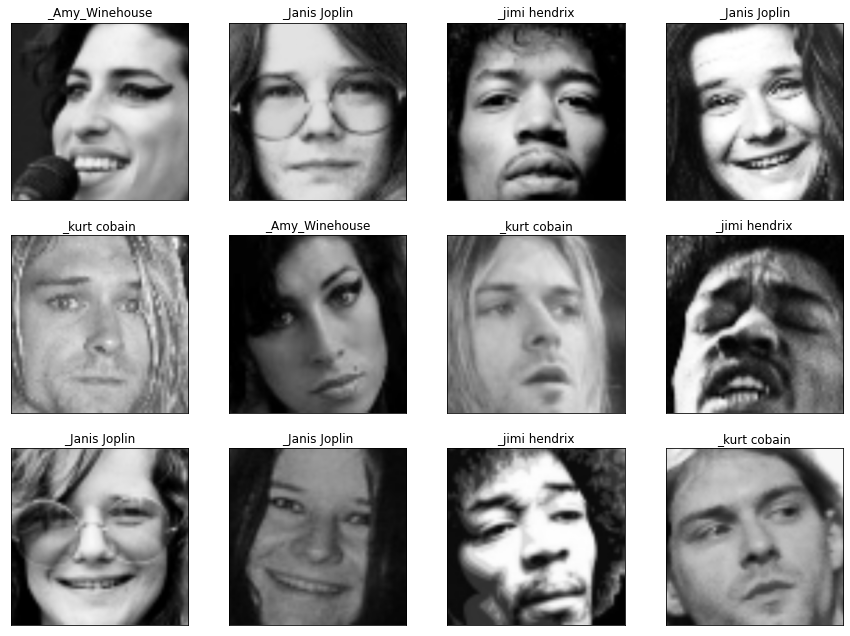

In [96]:
plot_df = train_df.sample(12).reset_index()
plt.figure(figsize=(15, 15))

for i in range(12):
    img_name = plot_df.loc[i, 'Filename']
    label_str = (plot_df.loc[i, 'ClassId'])
    plt.subplot(4,4,i+1)
    plt.imshow(plt.imread(os.path.join(train_path,label_str, img_name)))
    plt.title(label_str)
    plt.xticks([])
    plt.yticks([])
    plt.yticks([])

# 5. Image Generator 만들기

In [97]:
from keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(zoom_range=0.15,width_shift_range=0.2,height_shift_range=0.2,shear_range=0.15)
test_datagen = ImageDataGenerator()
val_datagen = ImageDataGenerator()
train_generator = train_datagen.flow_from_directory(train_path,target_size=(224, 224),batch_size=32,shuffle=True)
test_generator = test_datagen.flow_from_directory(test_path,target_size=(224,224),batch_size=32,shuffle=False)
val_generator = val_datagen.flow_from_directory(val_path,target_size=(224,224),batch_size=32,shuffle=False)

Found 421 images belonging to 4 classes.
Found 79 images belonging to 4 classes.
Found 69 images belonging to 4 classes.


# 6. Resnet 생성하기

## 6.1 Identity Block

In [98]:
def identity_block(X, f, filters, stage, block):
   
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    F1, F2, F3 = filters

    X_shortcut = X
   
    X = Conv2D(filters=F1, kernel_size=(1, 1), strides=(1, 1), padding='valid', name=conv_name_base + '2a', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2a')(X)
    X = Activation('relu')(X)

    X = Conv2D(filters=F2, kernel_size=(f, f), strides=(1, 1), padding='same', name=conv_name_base + '2b', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    X = Conv2D(filters=F3, kernel_size=(1, 1), strides=(1, 1), padding='valid', name=conv_name_base + '2c', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2c')(X)

    X = Add()([X, X_shortcut])# SKIP Connection
    X = Activation('relu')(X)

    return X

# 6.2 Convolutional Block

In [42]:
def convolutional_block(X, f, filters, stage, block, s=2):
   
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'

    F1, F2, F3 = filters

    X_shortcut = X

    X = Conv2D(filters=F1, kernel_size=(1, 1), strides=(s, s), padding='valid', name=conv_name_base + '2a', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2a')(X)
    X = Activation('relu')(X)

    X = Conv2D(filters=F2, kernel_size=(f, f), strides=(1, 1), padding='same', name=conv_name_base + '2b', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2b')(X)
    X = Activation('relu')(X)
    X = Conv2D(filters=F3, kernel_size=(1, 1), strides=(1, 1), padding='valid', name=conv_name_base + '2c', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2c')(X)

    X_shortcut = Conv2D(filters=F3, kernel_size=(1, 1), strides=(s, s), padding='valid', name=conv_name_base + '1', kernel_initializer=glorot_uniform(seed=0))(X_shortcut)
    X_shortcut = BatchNormalization(axis=3, name=bn_name_base + '1')(X_shortcut)

    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)

    return X

## 6.3 ResNet50

In [43]:
def ResNet50(input_shape=(224, 224, 3)):

    X_input = Input(input_shape)

    X = ZeroPadding2D((3, 3))(X_input)

    X = Conv2D(64, (7, 7), strides=(2, 2), name='conv1', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name='bn_conv1')(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3, 3), strides=(2, 2))(X)

    X = convolutional_block(X, f=3, filters=[64, 64, 256], stage=2, block='a', s=1)
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='b')
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='c')


    X = convolutional_block(X, f=3, filters=[128, 128, 512], stage=3, block='a', s=2)
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='b')
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='c')
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='d')

    X = convolutional_block(X, f=3, filters=[256, 256, 1024], stage=4, block='a', s=2)
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='b')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='c')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='d')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='e')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='f')

    X = X = convolutional_block(X, f=3, filters=[512, 512, 2048], stage=5, block='a', s=2)
    X = identity_block(X, 3, [512, 512, 2048], stage=5, block='b')
    X = identity_block(X, 3, [512, 512, 2048], stage=5, block='c')

    X = AveragePooling2D(pool_size=(2, 2), padding='same')(X)
    
    model = Model(inputs=X_input, outputs=X, name='ResNet50')

    return model

## 6.4 model 만들기

In [44]:
base_model = ResNet50(input_shape=(224, 224, 3))

In [45]:
headModel = base_model.output
headModel = Flatten()(headModel)
headModel=Dense(256, activation='relu', name='fc1',kernel_initializer=glorot_uniform(seed=0))(headModel)
headModel=Dense(128, activation='relu', name='fc2',kernel_initializer=glorot_uniform(seed=0))(headModel)
headModel = Dense( 10,activation='softmax', name='fc3',kernel_initializer=glorot_uniform(seed=0))(headModel)

In [46]:
model = Model(inputs=base_model.input, outputs=headModel)
model.summary()

# model은 여기서 끝...

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0          ['input_1[0][0]']                
                                                                                                  
 conv1 (Conv2D)                 (None, 112, 112, 64  9472        ['zero_padding2d[0][0]']         
                                )                                                                 
                                                                                              

#  7. 전이 학습 준비

In [47]:
from tensorflow.keras.applications import ResNet50

modelT = ResNet50(
      input_shape = (224,224,3),
      include_top = False,
      weights = 'imagenet'
    )

In [48]:
for layers in modelT.layers:
    layers.trainable = False

In [49]:
from keras.layers import  Dropout
y = Flatten()(modelT.output)
y = Dropout(0.5)(y)
y = Dense(4, activation = "softmax")(y)

modelT = keras.Model(modelT.input, y)
modelT.compile(loss = "categorical_crossentropy", optimizer = "adam", metrics = "accuracy")
modelT.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_2[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                            

In [50]:
es=EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience=20)

In [51]:
mc = ModelCheckpoint('./kaggle/working/model.h5', monitor='val_accuracy', mode='max' )

# 8. 학습

In [52]:
# History = modelT.fit_generator(train_generator,validation_data=val_generator,epochs=15,verbose=1, callbacks=[mc,es])

In [53]:
History = modelT.fit(train_generator,validation_data=val_generator,epochs=40,verbose=1, callbacks=[mc,es])

Epoch 1/40
12/12 [==============================] - ETA: 0s - loss: 9.4902 - accuracy: 0.4158

c:\Users\bamto\anaconda3\envs\tuto_haar\lib\site-packages\keras\engine\functional.py:1410: CustomMaskWarning:

Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.



12/12 [==============================] - 10s 448ms/step - loss: 9.4902 - accuracy: 0.4158 - val_loss: 0.7622 - val_accuracy: 0.8864
Epoch 2/40
12/12 [==============================] - 4s 342ms/step - loss: 4.4290 - accuracy: 0.7364 - val_loss: 3.1399 - val_accuracy: 0.8182
Epoch 3/40
12/12 [==============================] - 4s 353ms/step - loss: 1.9117 - accuracy: 0.8397 - val_loss: 2.2568 - val_accuracy: 0.8636
Epoch 4/40
12/12 [==============================] - 5s 376ms/step - loss: 1.4342 - accuracy: 0.8777 - val_loss: 2.4199 - val_accuracy: 0.9091
Epoch 5/40
12/12 [==============================] - 5s 388ms/step - loss: 0.8641 - accuracy: 0.8750 - val_loss: 3.1624 - val_accuracy: 0.8864
Epoch 6/40
12/12 [==============================] - 5s 373ms/step - loss: 1.1683 - accuracy: 0.8668 - val_loss: 2.5978 - val_accuracy: 0.8636
Epoch 7/40
12/12 [==============================] - 4s 360ms/step - loss: 1.0184 - accuracy: 0.9022 - val_loss: 2.8022 - val_accuracy: 0.9091
Epoch 8/40
12/12

# 9. 그래프 출력

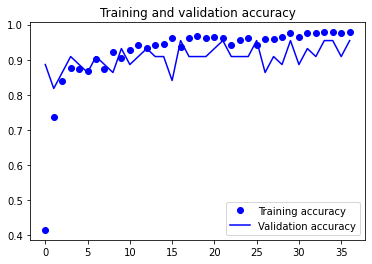

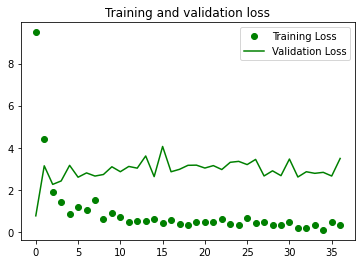

In [54]:
acc = History.history['accuracy']
val_acc = History.history['val_accuracy']
loss = History.history['loss']
val_loss = History.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'go', label='Training Loss')
plt.plot(epochs, val_loss, 'g', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

# 10. 예측하기

In [55]:
test_loss, test_acc = modelT.evaluate(test_generator, steps=len(test_generator), verbose=1)
print('Loss: %.3f' % (test_loss * 100.0))
print('Accuracy: %.3f' % (test_acc * 100.0)) 

2/2 [==============================] - 1s 459ms/step - loss: 4.5806 - accuracy: 0.8600
Loss: 458.058
Accuracy: 86.000


In [56]:
from sklearn.metrics import classification_report

In [57]:
y_val = test_generator.classes
y_pred = modelT.predict(test_generator)
y_pred = np.argmax(y_pred,axis=1)

In [58]:
print(classification_report(y_val,y_pred))

              precision    recall  f1-score   support

           0       0.79      1.00      0.88        15
           1       1.00      0.64      0.78        11
           2       0.90      0.82      0.86        11
           3       0.86      0.92      0.89        13

    accuracy                           0.86        50
   macro avg       0.89      0.84      0.85        50
weighted avg       0.88      0.86      0.86        50



In [59]:
class_indices = test_generator.class_indices
indices = {v:k for k,v in class_indices.items()}

In [60]:
filenames = test_generator.filenames

In [61]:
val_df = pd.DataFrame()
val_df['filename'] = filenames
val_df['actual'] = y_val
val_df['predicted'] = y_pred
val_df['actual'] = val_df['actual'].apply(lambda x: indices[x])
val_df['predicted'] = val_df['predicted'].apply(lambda x: indices[x])
val_df.loc[val_df['actual']==val_df['predicted'],'Same'] = True
val_df.loc[val_df['actual']!=val_df['predicted'],'Same'] = False
val_df.head(10)

,filename,actual,predicted,Same
0,_Amy_Winehouse\_Amy_Winehouse_109.png,_Amy_Winehouse,_Amy_Winehouse,True
1,_Amy_Winehouse\_Amy_Winehouse_114.png,_Amy_Winehouse,_Amy_Winehouse,True
2,_Amy_Winehouse\_Amy_Winehouse_142.png,_Amy_Winehouse,_Amy_Winehouse,True
3,_Amy_Winehouse\_Amy_Winehouse_18.png,_Amy_Winehouse,_Amy_Winehouse,True
4,_Amy_Winehouse\_Amy_Winehouse_2.png,_Amy_Winehouse,_Amy_Winehouse,True
5,_Amy_Winehouse\_Amy_Winehouse_28.png,_Amy_Winehouse,_Amy_Winehouse,True
6,_Amy_Winehouse\_Amy_Winehouse_35.png,_Amy_Winehouse,_Amy_Winehouse,True
7,_Amy_Winehouse\_Amy_Winehouse_45.png,_Amy_Winehouse,_Amy_Winehouse,True
8,_Amy_Winehouse\_Amy_Winehouse_51.png,_Amy_Winehouse,_Amy_Winehouse,True
9,_Amy_Winehouse\_Amy_Winehouse_70.png,_Amy_Winehouse,_Amy_Winehouse,True


In [62]:
val_df = val_df.sample(frac=1).reset_index(drop=True)

# 11. 예측비교하기

In [63]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
img_size = 224
def readImage(path):
    img = load_img(path,color_mode='rgb',target_size=(img_size,img_size))
    img = img_to_array(img)
    img = img/255.
    
    return img

def display_images(temp_df):
    temp_df = temp_df.reset_index(drop=True)
    plt.figure(figsize = (20 , 20))
    n = 0
    for i in range(15):
        n+=1
        plt.subplot(5 , 5, n)
        plt.subplots_adjust(hspace = 0.5 , wspace = 0.3)
        image = readImage(f"./dataset/crop_img/{temp_df.filename[i]}")
        plt.imshow(image)
        plt.title(f'A: {temp_df.actual[i]} P: {temp_df.predicted[i]}')

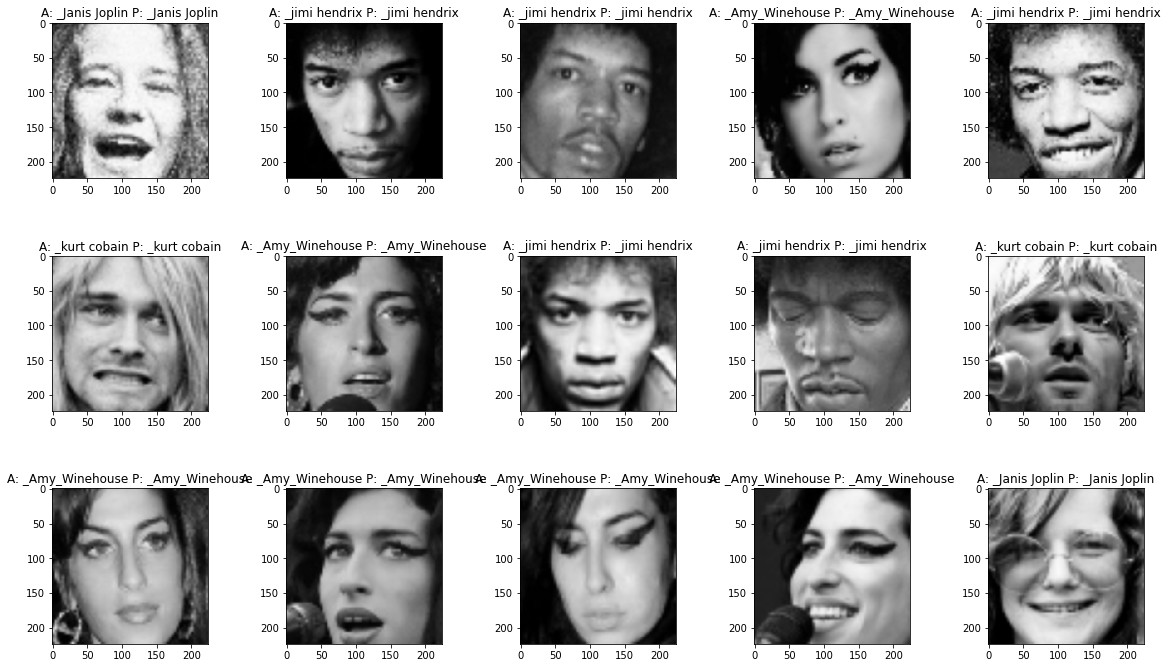

In [64]:
display_images(val_df[val_df['Same']==True])

KeyError: 7

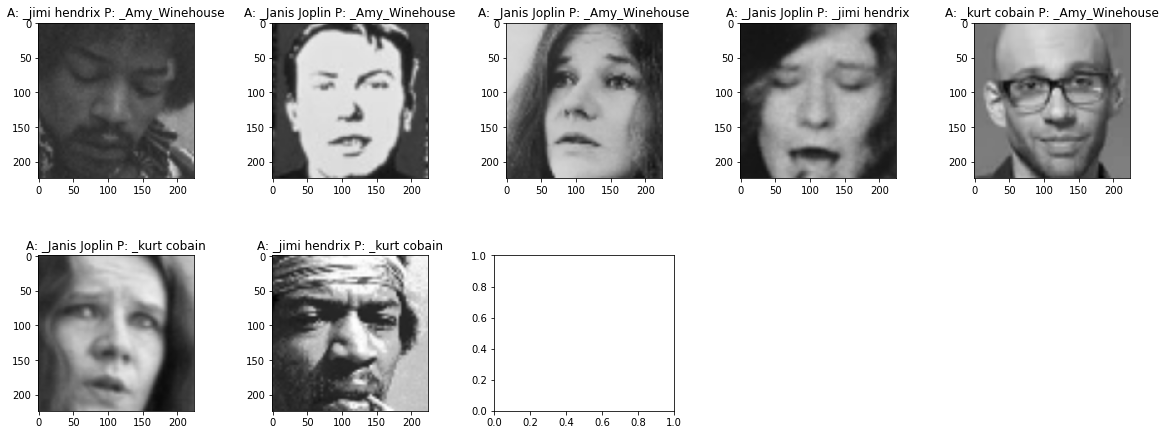

In [66]:
display_images(val_df[val_df['Same']!=True])

# 12. 매트릭스

In [67]:
cm = confusion_matrix(y_true=y_val, y_pred=y_pred)

In [68]:
def plot_confusion_matrix(cm, classes,normalize=False,title='Confusion matrix',cmap=plt.cm.Blues):
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
        print(cm)
    
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
        horizontalalignment="center",
        color="white" if cm[i, j] > thresh else "black")
        plt.tight_layout()
        plt.ylabel('True label')
        plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[15  0  0  0]
 [ 2  7  1  1]
 [ 1  0  9  1]
 [ 1  0  0 12]]


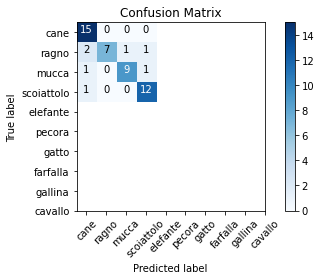

In [69]:
cm_plot_labels = ['Amy', 'Janis', 'jimi', 'kurt']

plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix')